Import the libraries necessary to analize data

In [428]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr

In [429]:
df = pd.read_csv('incidents_df_joined.csv', low_memory=False, sep=',', parse_dates=['date'])

Change data types to match the content of each attribute (setting to NaN non-numerical values in numerical attributes)

In [430]:
df["date"] = df["date"].astype("datetime64[ns]")
df["state"] = df["state"].astype("string")
df["city_or_county"] = df["city_or_county"].astype("string")
df["address"] = df["address"].astype("string")
df["congressional_district"] = df["congressional_district"].astype("Int64")
df["state_house_district"] = df["state_house_district"].astype("Int64")
df["state_senate_district"] = df["state_senate_district"].astype("Int64")
df["participant_age1"] = df["participant_age1"].astype("Int64")
df["min_age_participants"] = pd.to_numeric(df["min_age_participants"], errors="coerce").astype("Int64")
df["max_age_participants"] = pd.to_numeric(df["max_age_participants"], errors="coerce").astype("Int64")
df["avg_age_participants"] = pd.to_numeric(df["avg_age_participants"], errors="coerce").astype("float64")
df[df['participant_gender1'] == 'Male, female'] = np.nan
df["participant_gender1"] = df["participant_gender1"].astype("string")
df["participant_age_group1"] = df["participant_age_group1"].astype("string")
df["n_participants_teen"] = pd.to_numeric(df["n_participants_teen"], errors="coerce").astype("Int64")
df["n_participants_child"] = pd.to_numeric(df["n_participants_child"], errors="coerce").astype("Int64")
df["n_participants_adult"] = pd.to_numeric(df["n_participants_adult"], errors="coerce").astype("Int64")
df["n_males"] = pd.to_numeric(df["n_males"], errors="coerce").astype("Int64")
df["n_females"] = pd.to_numeric(df["n_females"], errors="coerce").astype("Int64")
df["n_killed"] = pd.to_numeric(df["n_killed"], errors="coerce").astype("Int64")
df["n_injured"] = pd.to_numeric(df["n_injured"], errors="coerce").astype("Int64")
df["n_arrested"] = pd.to_numeric(df["n_arrested"], errors="coerce").astype("Int64")
df["n_unharmed"] = pd.to_numeric(df["n_unharmed"], errors="coerce").astype("Int64")
df["n_participants"] = pd.to_numeric(df["n_participants"], errors="coerce").astype("Int64")
df["notes"] = df["notes"].astype("string")
df["incident_characteristics1"] = df["incident_characteristics1"].astype("string")
df["incident_characteristics2"] = df["incident_characteristics2"].astype("string")
df["party"] = df["party"].astype("string")
df["candidatevotes"] = df["candidatevotes"].astype("Int64")
df["totalvotes"] = df["totalvotes"].astype("Int64")
df["total_votes_for_state"] = df["total_votes_for_state"].astype("Int64")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199379 entries, 0 to 199378
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       199378 non-null  datetime64[ns]
 1   state                      199378 non-null  string        
 2   city_or_county             199378 non-null  string        
 3   address                    185727 non-null  string        
 4   latitude                   199312 non-null  float64       
 5   longitude                  199312 non-null  float64       
 6   congressional_district     199378 non-null  Int64         
 7   state_house_district       178207 non-null  Int64         
 8   state_senate_district      184239 non-null  Int64         
 9   participant_age1           136186 non-null  Int64         
 10  participant_age_group1     161304 non-null  string        
 11  participant_gender1        166715 non-null  string  

Deleting the rows with all NaN values

In [431]:
print(f"df len before: {len(df)}")
df.dropna(how='all', inplace=True)
print(f"df len after: {len(df)}")

df len before: 199379
df len after: 199378


Removing duplicates

In [432]:
print(df.duplicated().value_counts())
df = df.drop_duplicates(keep='first')
print(df.duplicated().value_counts())

False    199125
True        253
Name: count, dtype: int64
False    199125
Name: count, dtype: int64


Removing negative values

In [433]:
columns_to_check = ['participant_age1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants']
# Set values less than 0 to NaN for the specified columns
for i in columns_to_check:
    df.loc[df[i] < 0, i] = np.nan


## Age


As seen in D.U., given that there are some ouliers in the order of ~800 years of age, we decided to remove them by setting them all to NaN, considering that a person with more than 120 years has not ever lived [cite, wikipedia].

In [434]:
df.loc[(df["avg_age_participants"] > 120), "avg_age_participants"] = np.nan
df.loc[(df['min_age_participants'] > 120), "min_age_participants"] = np.nan
df.loc[(df['max_age_participants'] > 120), "max_age_participants"] = np.nan
df.loc[(df["participant_age1"] > 120), "participant_age1"] = np.nan

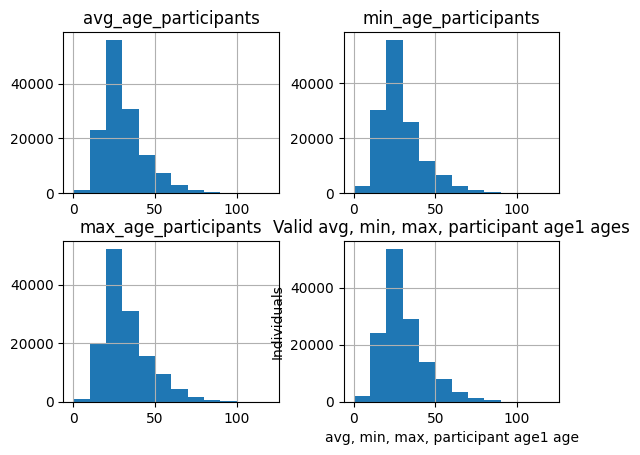

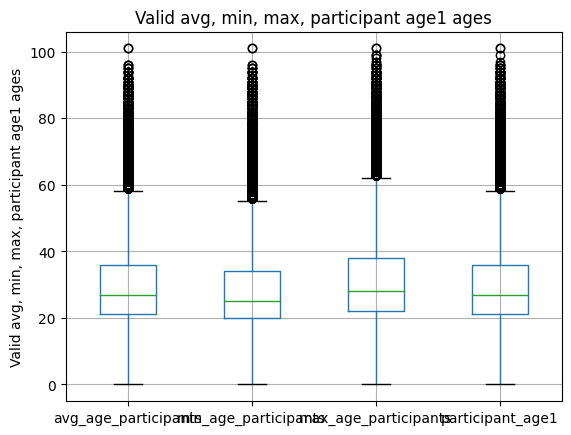

In [435]:

df.hist(column=['avg_age_participants', 'min_age_participants', 'max_age_participants', 'participant_age1'], bins=[i for i in range(0,121,10)])
plt.title("Valid avg, min, max, participant age1 ages")
plt.xlabel("avg, min, max, participant age1 age")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column=['avg_age_participants', 'min_age_participants', 'max_age_participants', 'participant_age1'])
plt.title("Valid avg, min, max, participant age1 ages")
plt.ylabel("Valid avg, min, max, participant age1 ages")
plt.show()

In [436]:
df[['avg_age_participants', 'participant_age1', 'min_age_participants', 'max_age_participants']].describe()

,avg_age_participants,participant_age1,min_age_participants,max_age_participants
count,136166.000000,136166.0,136170.0,136167.0
mean,29.974568,30.260674,28.32538,31.764561
std,12.461766,13.343979,12.498983,13.710215
min,0.000000,0.0,0.0,0.0
25%,21.000000,21.0,20.0,22.0
50%,27.000000,27.0,25.0,28.0
75%,36.000000,36.0,34.0,38.0
max,101.000000,101.0,101.0,101.0


In [437]:
print(f"% of no child in incidents: {df[df['n_participants_child'] == 0]['n_participants_child'].count() / len(df['n_participants_child'])}")
print(f"% of no teen in incidents: {df[df['n_participants_teen'] == 0]['n_participants_teen'].count() / len(df['n_participants_teen'])}")
print(f"% of no adult in incidents: {df[df['n_participants_adult'] == 0]['n_participants_adult'].count() / len(df['n_participants_adult'])}")

% of no child in incidents: 0.7934965473948524
% of no teen in incidents: 0.7230182046453233
% of no adult in incidents: 0.051661016949152545


We notice from eliminated obvious outliers (>120 and <0 years of age) and plotting the results that [avg_age,min_age,max_age]_participants are very similar (same min and max age, similar mean and median), so we decide that we will further explore their correlation. 

We check if when avg_age_participants is 0 or null, we can infer it by calcultating the avg based on min_age_participants and max_age_participants, and we found 0 rows available.
This is a further motivation to delete min and max age participants

In [438]:
df[((df['avg_age_participants'] == 0) | (df['avg_age_participants'].isna())) & (((df['min_age_participants'] > 0) & (df['min_age_participants'].notna())) & ((df['max_age_participants'] > 0) & df['min_age_participants'].notna() ))] [['avg_age_participants', 'min_age_participants', 'max_age_participants']]

,avg_age_participants,min_age_participants,max_age_participants


In [439]:
df[df["n_participants"] == 0]["avg_age_participants"].unique()

array([nan])

In [440]:
columns_to_check = ["participant_age1", "participant_age_group1", "participant_gender1", "min_age_participants", "avg_age_participants", "max_age_participants", "n_participants_child", "n_participants_teen", "n_participants_adult"]
df[df["avg_age_participants"].isna()][columns_to_check]

,participant_age1,participant_age_group1,participant_gender1,min_age_participants,avg_age_participants,max_age_participants,n_participants_child,n_participants_teen,n_participants_adult
1,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>
4,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>
7,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>
8,<NA>,<NA>,Male,<NA>,NaN,<NA>,<NA>,<NA>,<NA>
9,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...
199333,<NA>,Adult 18+,Male,<NA>,NaN,<NA>,0,0,1
199334,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>
199336,<NA>,<NA>,Male,<NA>,NaN,<NA>,<NA>,<NA>,<NA>
199367,<NA>,Adult 18+,<NA>,<NA>,NaN,<NA>,0,0,4


## Date

Analysis and cleaning of the date attribute

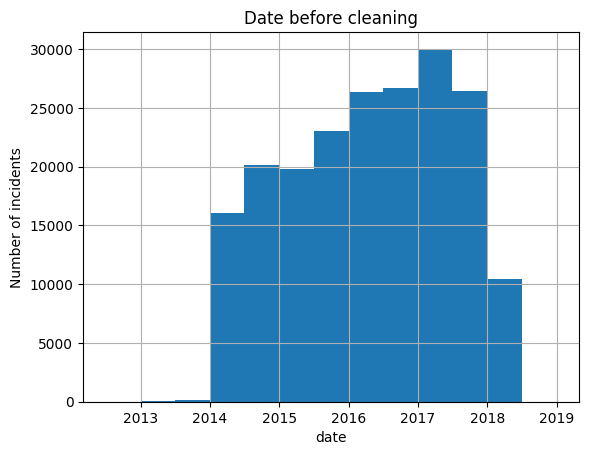

In [441]:
df.hist(column=["date"],   bins=[datetime.datetime(2012,7,1,0,0), datetime.datetime(2013,1,1,0,0), datetime.datetime(2013,7,1,0,0),
                             datetime.datetime(2014,1,1,0,0), datetime.datetime(2014,7,1,0,0), datetime.datetime(2015,1,1,0,0),
                             datetime.datetime(2015,7,1,0,0), datetime.datetime(2016,1,1,0,0), datetime.datetime(2016,7,1,0,0),
                             datetime.datetime(2017,1,1,0,0), datetime.datetime(2017,7,1,0,0), datetime.datetime(2018,1,1,0,0),
                             datetime.datetime(2018,7,1,0,0), datetime.datetime(2019,1,1,0,0)])
plt.title("Date before cleaning")
plt.xlabel("date")
plt.ylabel("Number of incidents")
plt.show()

We considered all dates after 2023-10-01 (the date we received the dataset) to be ouliers, in particular error in the data

TODO: 2018 analyze separately

As seen in D.U., the year 2013 is under represented with only 242 records, so we decide to drop them. 

In [442]:
df['date'].dt.year.value_counts().sort_index()

date
2013      242
2014    36248
2015    42804
2016    53051
2017    56365
2018    10415
Name: count, dtype: int64

In [443]:
df_with_2013 = len(df)
df = df[df['date'].dt.year > 2013]
print(df_with_2013 - len(df))

242


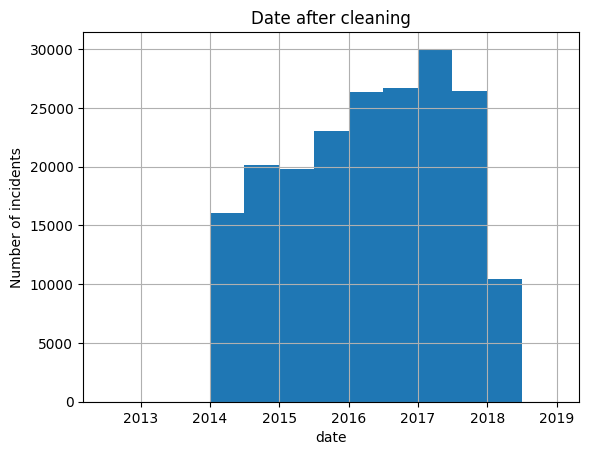

In [444]:
df.hist(column=["date"],   bins=[datetime.datetime(2012,7,1,0,0), datetime.datetime(2013,1,1,0,0), datetime.datetime(2013,7,1,0,0),
                             datetime.datetime(2014,1,1,0,0), datetime.datetime(2014,7,1,0,0), datetime.datetime(2015,1,1,0,0),
                             datetime.datetime(2015,7,1,0,0), datetime.datetime(2016,1,1,0,0), datetime.datetime(2016,7,1,0,0),
                             datetime.datetime(2017,1,1,0,0), datetime.datetime(2017,7,1,0,0), datetime.datetime(2018,1,1,0,0),
                             datetime.datetime(2018,7,1,0,0), datetime.datetime(2019,1,1,0,0)])
plt.title("Date after cleaning")
plt.xlabel("date")
plt.ylabel("Number of incidents")
plt.show()

# Geographical info

## Latitude and longitude

In [445]:
central_block = ((df["latitude"] <= 49.3457868) & (df["latitude"] >= 24.396308) & (df["longitude"] >= -125.000000) & (df["longitude"] <= -66.934570))
alaska_block = ((df["latitude"] <= 71.635993) & (df["latitude"] >= 53.67068) & (df["longitude"] >= -173.59497) & (df["longitude"] <= -129.152344))
hawaii_block = ((df["latitude"] <= 22.674847) & (df["latitude"] >= 17.790535) & (df["longitude"] >= -161.389160) & (df["longitude"] <= -153.237305))

df[~(central_block | alaska_block | hawaii_block)][['latitude', 'longitude']].value_counts(dropna=False)

latitude  longitude
NaN       NaN          66
Name: count, dtype: int64

We consider the triple <date,latitude,longitude> to be a key identifying an incident. We decided to eliminate the records with these 3 values duplicates. 

In [446]:
df[df.duplicated(subset=['latitude', 'longitude', 'date'], keep=False)][['latitude', 'longitude', 'date']].value_counts()

latitude  longitude  date      
36.7387   -119.7900  2018-01-16    6
                     2018-03-17    5
38.6303   -90.1936   2017-08-23    4
33.5736   -81.7178   2015-02-08    4
36.7387   -119.7900  2018-03-18    4
                                  ..
33.6356   -84.4333   2014-07-09    2
                     2014-10-10    2
                     2015-09-14    2
                     2016-03-03    2
61.6139   -149.4510  2016-07-28    2
Name: count, Length: 912, dtype: int64

In [447]:
print(len(df))
#df = df.drop_duplicates(subset=["date", "latitude", "longitude"]).append(df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])])
df = pd.concat([df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])], df.drop_duplicates(subset=["date", "latitude", "longitude"])])
df.drop_duplicates(inplace=True)
print(len(df))

198883
197925


In [448]:
df[df.duplicated(subset=['latitude', 'longitude', 'date'], keep=False)][['latitude', 'longitude', 'date']].value_counts()

Series([], Name: count, dtype: int64)

## Filling of missing values and outliers

TODO: check variance

In [449]:
#Sostituisco i valori NaN di latitude e longitude, con i valori delle righe aventi lo stesso state e la stessa city_or_county
df[['latitude', 'longitude']] = df.groupby(["state", "city_or_county"],group_keys=False)[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df[['latitude', 'longitude']] = df.groupby("state",group_keys=False)[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df[['latitude', 'longitude']].isna().any()

latitude     False
longitude    False
dtype: bool

## Congressional District, State House District, State Senate District

By examining the columns ‘congressional_district’, ‘state_house_district’, and ‘state_senate_district’, we observe that the columns ‘state_house_district’ and ‘state_senate_district’ represent further subdivisions of the US territory, which are not pertinent to our analysis. We will utilize the ‘congressional_district’ column to study the territorial divisions.

In [450]:
df.drop(columns=['state_house_district', 'state_senate_district'], inplace=True)

# Participant quantity information 
('n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants')

## N killed, injured, arrested, unharmed

N killed and N injured have no NaN values after the previous steps of cleaning, we proceed to fix N arrested and N unharmed null values.

In [451]:
df[['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 197925 entries, 85424 to 199339
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   n_killed    197925 non-null  Int64
 1   n_injured   197925 non-null  Int64
 2   n_arrested  173539 non-null  Int64
 3   n_unharmed  173539 non-null  Int64
dtypes: Int64(4)
memory usage: 8.3 MB


In [452]:
columns_to_check = ['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']
for column in columns_to_check:
    df.loc[df[column] > df['n_participants'], column] = np.nan

In [453]:
df[columns_to_check].info()

<class 'pandas.core.frame.DataFrame'>
Index: 197925 entries, 85424 to 199339
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   n_killed    197925 non-null  Int64
 1   n_injured   197925 non-null  Int64
 2   n_arrested  173539 non-null  Int64
 3   n_unharmed  173539 non-null  Int64
dtypes: Int64(4)
memory usage: 8.3 MB


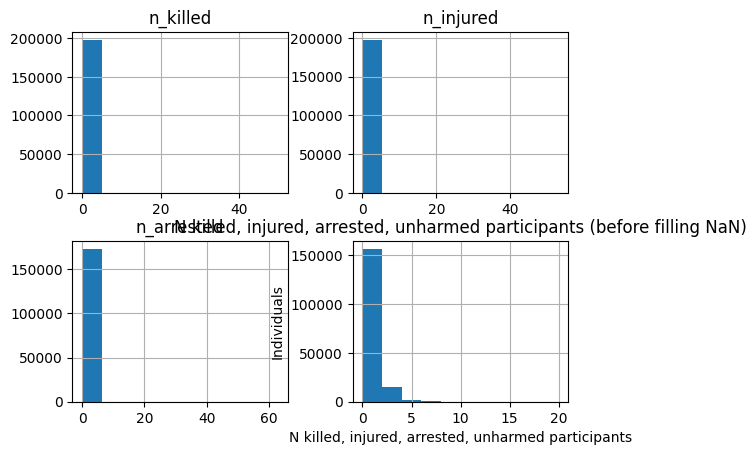

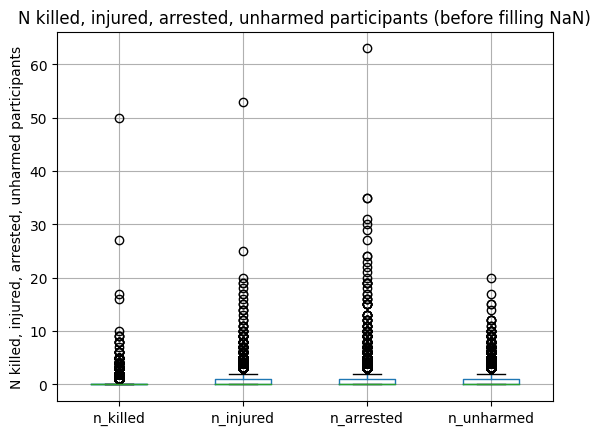

In [454]:
df.hist(column=columns_to_check)
plt.title("N killed, injured, arrested, unharmed participants (before filling NaN)")
plt.xlabel("N killed, injured, arrested, unharmed participants")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column=columns_to_check)
plt.title("N killed, injured, arrested, unharmed participants (before filling NaN)")
plt.ylabel("N killed, injured, arrested, unharmed participants")
plt.show()

As we can see, there are no N killed, injured, arrested, unharmed that exceeds the number of participants in that incident

We put to 0 arrested and unharmed in all the cases in which there is 0 participants.

In [455]:
df.loc[df["n_participants"] == 0, ['n_arrested', 'n_unharmed']] = 0

Fill the remaining null values with the mode. # TODO calculate the MAD

In [456]:
def fillna_group_arrested_unharmed(group):
    group["n_arrested"] = group["n_arrested"].fillna(np.round(group["n_arrested"].mean(),0))
    group["n_unharmed"] = group["n_unharmed"].fillna(np.round(group["n_unharmed"].mean(),0))
    return group

In [457]:
df = df.groupby("n_participants").apply(fillna_group_arrested_unharmed).reset_index(drop=True)

In [458]:
df[['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197925 entries, 0 to 197924
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   n_killed    197925 non-null  Int64
 1   n_injured   197925 non-null  Int64
 2   n_arrested  197925 non-null  Int64
 3   n_unharmed  197925 non-null  Int64
dtypes: Int64(4)
memory usage: 6.8 MB


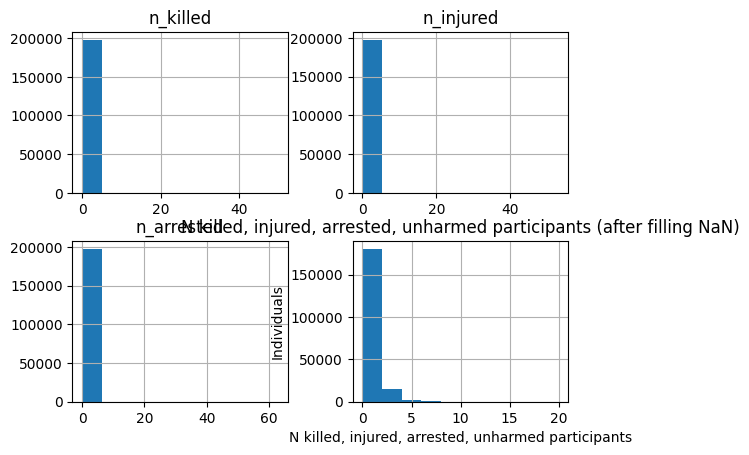

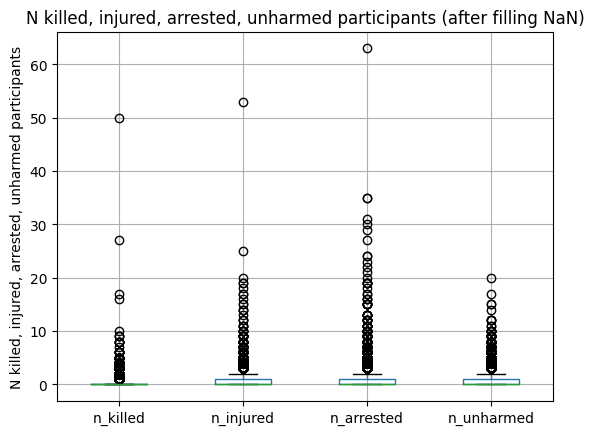

In [459]:
df.hist(column=columns_to_check)
plt.title("N killed, injured, arrested, unharmed participants (after filling NaN)")
plt.xlabel("N killed, injured, arrested, unharmed participants")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column=columns_to_check)
plt.title("N killed, injured, arrested, unharmed participants (after filling NaN)")
plt.ylabel("N killed, injured, arrested, unharmed participants")
plt.show()

## N participants [child, teen, adult] and n males and n females

As we observed in D.U., for n_participants[_child,_teen,_adult] there are outliers represented by enormous values. In data preparation, we decided to clean these data putting them to nan.

In [460]:
# n_participants has no evident outliers as seen in D.U., we use max participants as threshold value to filter out the outliers
max_participants = df['n_participants'].max()

df.loc[(df["n_participants_child"] > max_participants), "n_participants_child"] = np.nan
df.loc[(df["n_participants_teen"] > max_participants), "n_participants_teen"] = np.nan
df.loc[(df["n_participants_adult"] > max_participants), "n_participants_adult"] = np.nan

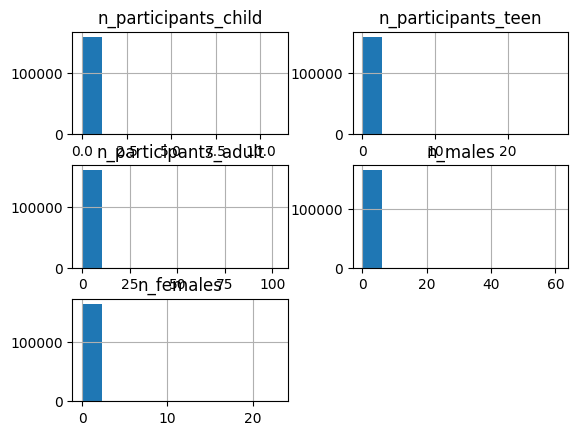

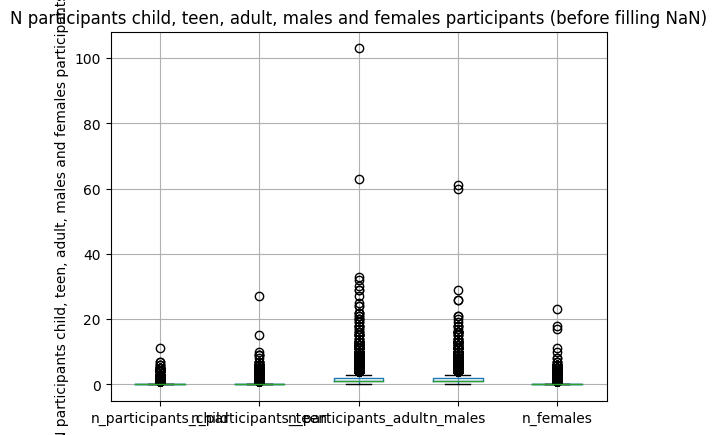

In [461]:
df.hist(column=["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"])
plt.title("N participants child, teen, adult, males and females (before filling NaN)")
plt.xlabel("N participants child, teen, adult, males and females participants")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column=["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"])
plt.title("N participants child, teen, adult, males and females participants (before filling NaN)")
plt.ylabel("N participants child, teen, adult, males and females participants")
plt.show()

If n participants 0, fill all the other info about the number of people to 0

In [462]:
df.loc[df["n_participants"] == 0, ["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]] = 0

In [463]:
#Utilizzerà questi valori per sosituire "n_participants" nel caso somma tra male e female è pari alla somma tra teen,child e adults.
#La modifica per quanto riguarda "n_participants" è fatta solo se è diversa da tutte le altre somme delle varie colonne:
#1) females + males
#2) child + adult + teen
#3) killed+injured+unharmed+arrested

#Nel caso in cui n_participants sia almeno uguale ad una delle altre somme => lascia uguale.
df['substitute_values'] = df['n_females'] + df['n_males']

# Define the condition for substitution
condition = (
    ((df['n_females'] + df['n_males']) == (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult'])) &
    (df['n_participants'] != (df['n_females'] + df['n_males'])) 
)

# Update the "n_participants" column with the calculated values where the condition is met
df.loc[condition, 'n_participants'] = df.loc[condition, 'substitute_values']

# Drop the temporary "substitute_values" column if needed
df.drop(columns='substitute_values', inplace=True)

df[condition][["n_participants","n_males","n_females", "n_participants_teen", "n_participants_child", "n_participants_adult"]]

,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult
108152,1,1,0,0,0,1
108157,1,1,0,0,0,1
108186,1,1,0,0,0,1
108189,1,0,1,0,0,1
108224,1,1,0,0,0,1
...,...,...,...,...,...,...
197862,1,1,0,0,0,1
197867,14,12,2,4,0,10
197906,22,18,4,0,0,22
197908,20,13,7,8,0,12


In [464]:
df['n_participants_gender'] = df['n_females'] + df['n_males']
df['n_participants_age'] = df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult']

# null values can be ambiguous, we ignore them for now
df['n_participants_gender'] = df[df['n_participants_gender'].notna()]['n_participants_gender']
df['n_participants_age'] = df[df['n_participants_age'].notna()]['n_participants_age']


condition = (
    ((df['n_participants_gender']) != (df['n_participants_age']))   
)

print(f"Number of male e female != child + teen + adult:  {len(df[condition])}")

condition1 = condition & ((df['n_participants'] == (df['n_participants_gender'])))

print(f"Same condition as before but with n participants == female + male: {len(df[condition1])}")

condition2 = condition & ((df['n_participants'] == (df['n_participants_age'])) )

print(f"Same condition as before but with n participants == child + teen + adult: {len(df[condition2])}")

condition3 = condition & (((df['n_participants'] != df['n_participants_gender']) & (df['n_participants'] != df['n_participants_age'])))
                          
print(f"Same condition as before but with n participants != child + teen + adult and != n_males + n_females: {len(df[condition3])}")


Number of male e female != child + teen + adult:  13363
Same condition as before but with n participants == female + male: 8649
Same condition as before but with n participants == child + teen + adult: 4202
Same condition as before but with n participants != child + teen + adult and != n_males + n_females: 512


In [465]:
df.loc[condition3, ["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females","n_participants_age","n_participants_gender"]] = np.nan
df.loc[condition2, ["n_males","n_females","n_participants_gender"]] = np.nan
df.loc[condition1, ["n_participants_child","n_participants_teen", "n_participants_adult","n_participants_age"]] = np.nan
df.loc[df["n_participants_age"] != df["n_participants"],["n_participants_child","n_participants_teen", "n_participants_adult","n_participants_age"]] = np.nan
df.loc[df["n_participants_gender"] != df["n_participants"],["n_males","n_females", "n_participants_gender"]] = np.nan

df.drop(columns=['n_participants_age', 'n_participants_gender'], inplace=True)


In [466]:
df[["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197925 entries, 0 to 197924
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   n_participants_child  172824 non-null  Int64
 1   n_participants_teen   172824 non-null  Int64
 2   n_participants_adult  172824 non-null  Int64
 3   n_males               181641 non-null  Int64
 4   n_females             181641 non-null  Int64
dtypes: Int64(5)
memory usage: 8.5 MB


In [467]:
df[df["n_participants"] == 17][["n_participants","n_males","n_females",'n_participants_teen','n_participants_child','n_participants_adult']]


,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult
197881,17,<NA>,<NA>,0,0,17
197882,17,13,4,<NA>,<NA>,<NA>
197883,17,11,6,<NA>,<NA>,<NA>
197884,17,<NA>,<NA>,<NA>,<NA>,<NA>
197885,17,16,1,0,1,16
197886,17,<NA>,<NA>,<NA>,<NA>,<NA>
197887,17,10,7,0,0,17


In [468]:
#putting in males the first element from males_females
group_by = df.groupby("n_participants",group_keys=False)
for name, group in group_by:
    males_mean = group["n_males"].mean()
    females_mean = group["n_females"].mean()
    participants_child_mean = group["n_participants_child"].mean()
    participants_teen_mean = group["n_participants_teen"].mean()
    participants_adult_mean = group["n_participants_adult"].mean()

    if (pd.notna(males_mean) and pd.notna(females_mean)):
        df.loc[(df["n_males"].isna()) & (df["n_participants"] == name),"n_males"] = np.round(males_mean,0)
        df.loc[(df["n_females"].isna()) & (df["n_participants"] == name),"n_females"] = np.round(females_mean,0)

    if (pd.notna(participants_child_mean) and pd.notna(participants_teen_mean) and pd.notna(participants_adult_mean)):
        df.loc[(df["n_participants_child"].isna()) & (df["n_participants"] == name),"n_participants_child"] = np.round(participants_child_mean,0)
        df.loc[(df["n_participants_teen"].isna()) & (df["n_participants"] == name),"n_participants_teen"] = np.round(participants_teen_mean,0)
        df.loc[(df["n_participants_adult"].isna()) & (df["n_participants"] == name),"n_participants_adult"] = np.round(participants_adult_mean,0)


In [469]:
df[df["n_participants"] == 17][["n_participants","n_males","n_females",'n_participants_teen','n_participants_child','n_participants_adult']]


,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult
197881,17,12,4,0,0,17
197882,17,13,4,0,0,17
197883,17,11,6,0,0,17
197884,17,12,4,0,0,17
197885,17,16,1,0,1,16
197886,17,12,4,0,0,17
197887,17,10,7,0,0,17


In [470]:
df[["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197925 entries, 0 to 197924
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   n_participants_child  197922 non-null  Int64
 1   n_participants_teen   197922 non-null  Int64
 2   n_participants_adult  197922 non-null  Int64
 3   n_males               197917 non-null  Int64
 4   n_females             197917 non-null  Int64
dtypes: Int64(5)
memory usage: 8.5 MB


All the data in which we can't reconstruct the mean were few (only 8) and for this reason were dropped

In [471]:
df[(df["n_males"].isna() & df["n_females"].isna()) | (df['n_participants_teen'].isna() & df['n_participants_child'].isna() & df['n_participants_adult'].isna())][["n_participants","n_males","n_females",'n_participants_teen','n_participants_child','n_participants_adult']]

,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult
197907,24,<NA>,<NA>,0,0,24
197909,24,<NA>,<NA>,0,0,24
197910,24,<NA>,<NA>,0,0,24
197916,30,<NA>,<NA>,0,0,30
197920,37,<NA>,<NA>,<NA>,<NA>,<NA>
197921,47,<NA>,<NA>,<NA>,<NA>,<NA>
197922,52,<NA>,<NA>,<NA>,<NA>,<NA>
197924,103,<NA>,<NA>,0,0,103


In [472]:
df = df[~((df["n_males"].isna() & df["n_females"].isna()) | (df['n_participants_teen'].isna() & df['n_participants_child'].isna() & df['n_participants_adult'].isna()))]

The rounded mean missed only for few other records (3) that for now we decided to drop them. 

In [473]:
condition = (
    ((df['n_females'] + df['n_males']) != (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult']))   
)

print(f"Number of male e female != child + teen + adult:  {len(df[condition])}")

Number of male e female != child + teen + adult:  3


In [474]:
df.loc[condition, ["n_participants","n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]]

,n_participants,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females
197881,17,0,0,17,12,4
197884,17,0,0,17,12,4
197886,17,0,0,17,12,4


In [475]:
df = df[~condition]

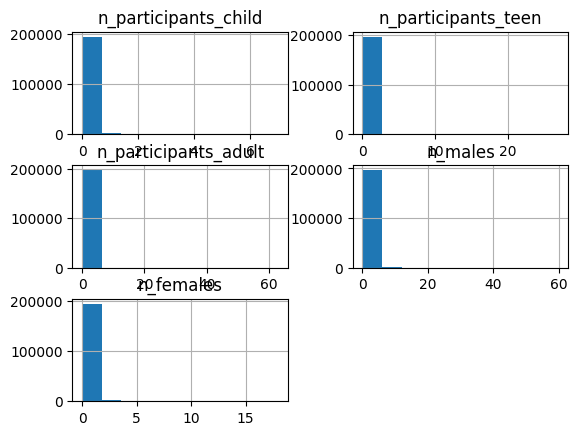

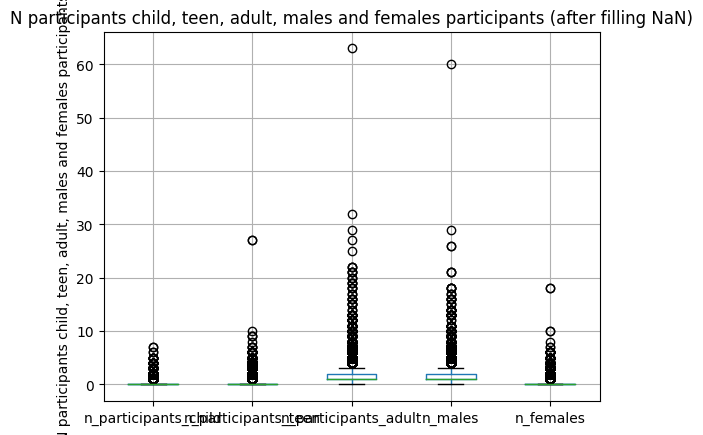

In [476]:
df.hist(column=["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"])
plt.title("N participants child, teen, adult, males and females (after filling NaN)")
plt.xlabel("N participants child, teen, adult, males and females participants")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column=["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"])
plt.title("N participants child, teen, adult, males and females participants (after filling NaN)")
plt.ylabel("N participants child, teen, adult, males and females participants")
plt.show()

# Incident characteristics 1

In [477]:
df['incident_characteristics1'].info()

<class 'pandas.core.series.Series'>
Index: 197914 entries, 0 to 197923
Series name: incident_characteristics1
Non-Null Count   Dtype 
--------------   ----- 
197641 non-null  string
dtypes: string(1)
memory usage: 3.0 MB


In [478]:
df['incident_characteristics1'] = df['incident_characteristics1'].fillna(df['incident_characteristics1'].mode()[0]) #?

In [479]:
df['incident_characteristics1'].value_counts(dropna=True)

incident_characteristics1
Shot - Wounded/Injured                               77433
Shot - Dead (murder, accidental, suicide)            38819
Non-Shooting Incident                                35675
Shots Fired - No Injuries                            28708
Institution/Group/Business                            3696
Armed robbery with injury/death and/or evidenc...     3224
TSA Action                                            2457
Possession (gun(s) found during commission of ...     1030
Brandishing/flourishing/open carry/lost/found          976
Shots fired, no action (reported, no evidence ...      875
Drug involvement                                       831
Home Invasion                                          800
Gun(s) stolen from owner                               669
Officer Involved Incident                              487
ATF/LE Confiscation/Raid/Arrest                        345
Animal shot/killed                                     271
Car-jacking                   

# Incident characteristics 2

In [480]:
df['incident_characteristics2'].info()

<class 'pandas.core.series.Series'>
Index: 197914 entries, 0 to 197923
Series name: incident_characteristics2
Non-Null Count   Dtype 
--------------   ----- 
118425 non-null  string
dtypes: string(1)
memory usage: 3.0 MB


In [481]:
print(f" percentage of null values: {df['incident_characteristics2'].isna().sum() / len(df['incident_characteristics2'])}")

 percentage of null values: 0.40163404306921185


In [482]:
df[df['incident_characteristics1'] == "Shot - Wounded/Injured" ][['incident_characteristics1','incident_characteristics2']].value_counts(dropna=False).head()

incident_characteristics1  incident_characteristics2                        
Shot - Wounded/Injured     <NA>                                                 38565
                           Shot - Dead (murder, accidental, suicide)             7108
                           Drive-by (car to street, car to car)                  5866
                           Accidental Shooting                                   3209
                           Armed robbery with injury/death and/or evidenc...     3011
Name: count, dtype: int64

For now, since incident_characteristics2 has 40% of missing values and add only further details that we consider useless for our analysis, we decided to drop it. 

In [483]:
df.drop(columns=['incident_characteristics2'], inplace=True)

# Correlation Matrix Analysis

In [484]:
corr_matrix = df[['participant_age1', 'participant_age_group1',
       'participant_gender1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants', 'povertyPercentage']].corr(numeric_only=True, method='pearson')
corr_matrix

,participant_age1,min_age_participants,avg_age_participants,max_age_participants,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,povertyPercentage
participant_age1,1.000000,0.878260,0.945387,0.926643,-0.177334,-0.256170,0.109591,-0.065534,0.067696,0.146681,-0.122233,-0.025916,-0.008665,-0.029498,0.033266
min_age_participants,0.878260,1.000000,0.951506,0.812162,-0.226368,-0.302624,-0.019999,-0.193070,-0.018982,0.061702,-0.152522,-0.108885,-0.045980,-0.183312,0.013536
avg_age_participants,0.945387,0.951506,1.000000,0.948623,-0.175819,-0.286476,0.087156,-0.100377,0.061805,0.136316,-0.121642,-0.053004,-0.020807,-0.063669,0.030005
max_age_participants,0.926643,0.812162,0.948623,1.000000,-0.110643,-0.232381,0.196619,0.015735,0.140880,0.196964,-0.076305,0.021600,0.009898,0.076438,0.043061
n_participants_child,-0.177334,-0.226368,-0.175819,-0.110643,1.000000,0.011838,-0.015817,0.081763,0.140637,0.062697,0.052604,-0.012359,0.107527,0.127849,0.031875
n_participants_teen,-0.256170,-0.302624,-0.286476,-0.232381,0.011838,1.000000,-0.088756,0.252610,0.116213,0.024424,0.113431,0.201504,0.077144,0.272564,0.013818
n_participants_adult,0.109591,-0.019999,0.087156,0.196619,-0.015817,-0.088756,1.000000,0.858159,0.390072,0.216086,0.331097,0.409661,0.478263,0.924130,0.067971
n_males,-0.065534,-0.193070,-0.100377,0.015735,0.081763,0.252610,0.858159,1.000000,0.055307,0.169472,0.333234,0.437150,0.478381,0.923307,0.060328
n_females,0.067696,-0.018982,0.061805,0.140880,0.140637,0.116213,0.390072,0.055307,1.000000,0.185931,0.167039,0.177057,0.179389,0.434541,0.052085
n_killed,0.146681,0.061702,0.136316,0.196964,0.062697,0.024424,0.216086,0.169472,0.185931,1.000000,-0.175072,-0.035045,-0.103986,0.224388,0.067164


<Axes: >

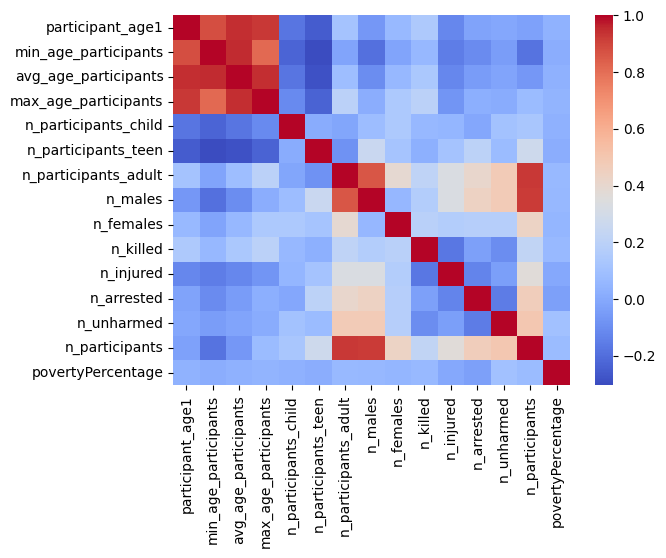

In [485]:
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')

As resulted from the plotting of correlation matrix, we can see that attributes related to the age i.e. participant_age1, min_age_participants, 	avg_age_participants, max_age_participants are all high correlated.
We decided to drop everything except avg_age_participants which has the most high correlation w.r.t. other attributes (>0.90) and gives us more general information about all the participants (w.r.t. e.g. participant_age1, which takes the age of one random person involved in the incident.)
Deleting participant_age1, participant_age_group1 and participant_gender1 becomes useless, so we delete also these attributes. 

In [486]:
df.drop(columns=['participant_age1', 'min_age_participants', 'max_age_participants', 'participant_age_group1', 'participant_gender1'], inplace=True)

## Filling missing values for avg_participants

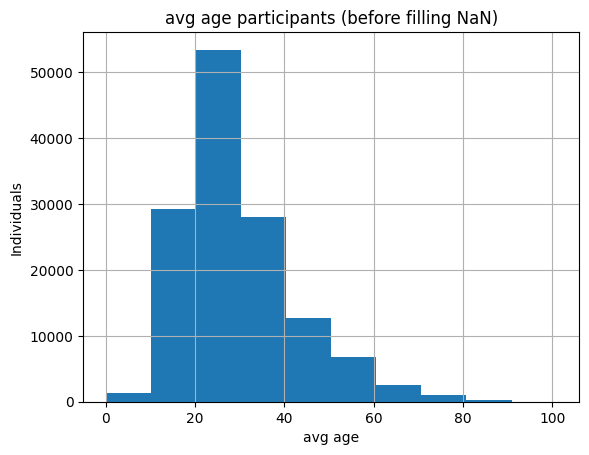

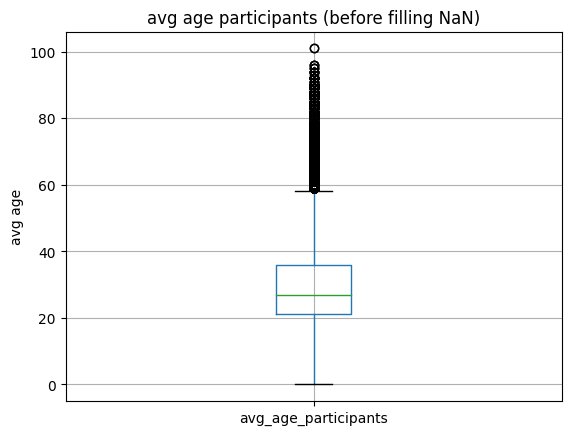

In [487]:
df.hist(column=["avg_age_participants"])
plt.title("avg age participants (before filling NaN)")
plt.xlabel("avg age")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column=["avg_age_participants"])
plt.title("avg age participants (before filling NaN)")
plt.ylabel("avg age")
plt.show()

In [488]:
df[df["n_participants"] == 0]['avg_age_participants'].value_counts(dropna=False)

avg_age_participants
NaN    21883
Name: count, dtype: int64

In [489]:
def fillna_group_avg_age_participants(group):
    avg_age_group = group["avg_age_participants"].mean()
    print(avg_age_group)
    if (pd.notna(avg_age_group)):
        group["avg_age_participants"] = group["avg_age_participants"].fillna(np.round(avg_age_group,0))
    return group
df = df.groupby("n_participants").apply(fillna_group_avg_age_participants).reset_index(drop=True)

#TODO: fix 
df.loc[(df["n_participants"] == 0), "avg_age_participants"] = 0


nan
30.095947883928844
31.001258750524478
28.56299938537185
26.939625850340136
26.372793801119244
25.715575620767495
25.729805013927578
26.240641711229948
25.166666666666668
28.523809523809526
27.444444444444443
24.823529411764707
26.818181818181817
27.0
30.285714285714285
32.333333333333336
23.0
31.333333333333332
28.5
26.5
nan
27.0
22.0
30.0
nan
33.0
20.0
26.0


In [490]:
columns_to_check = [ "avg_age_participants", "n_males", "n_females", "n_participants_child", "n_participants_teen", "n_participants_adult","n_participants"]
df[df["avg_age_participants"].isna()][columns_to_check]
#4 rows to fix

,avg_age_participants,n_males,n_females,n_participants_child,n_participants_teen,n_participants_adult,n_participants
197900,NaN,21,0,0,0,21,21
197901,NaN,21,0,0,0,21,21
197902,NaN,21,0,0,0,21,21
197909,NaN,29,0,0,0,29,29


In [491]:
df.loc[(df["avg_age_participants"].isna()), "avg_age_participants"] =  np.round(df["avg_age_participants"].mean())
df[df["n_participants"] == 21][columns_to_check]



,avg_age_participants,n_males,n_females,n_participants_child,n_participants_teen,n_participants_adult,n_participants
197900,27.0,21,0,0,0,21,21
197901,27.0,21,0,0,0,21,21
197902,27.0,21,0,0,0,21,21


TODO: FIX

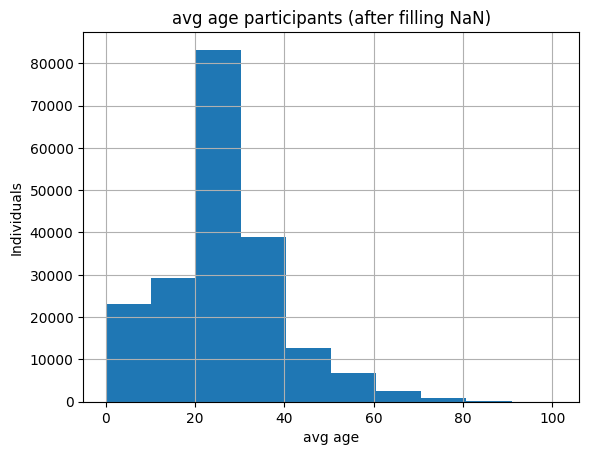

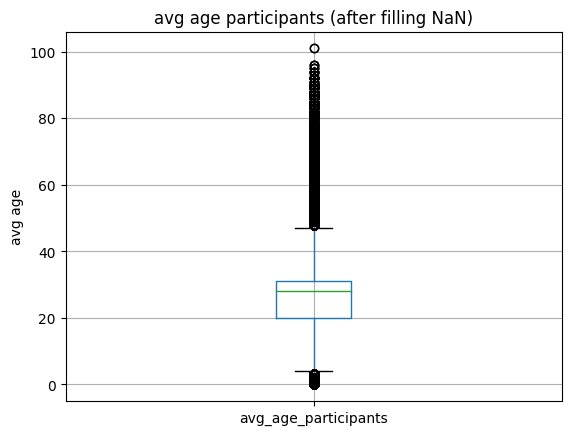

In [492]:
df.hist(column=["avg_age_participants"])
plt.title("avg age participants (after filling NaN)")
plt.xlabel("avg age")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column=["avg_age_participants"])
plt.title("avg age participants (after filling NaN)")
plt.ylabel("avg age")
plt.show()

In [493]:
df['n_participants_child'].value_counts().sort_index()

n_participants_child
0    194807
1      2579
2       440
3        61
4        15
5         8
6         2
7         2
Name: count, dtype: Int64

In [494]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       197914 non-null  datetime64[ns]
 1   state                      197914 non-null  string        
 2   city_or_county             197914 non-null  string        
 3   address                    184525 non-null  string        
 4   latitude                   197914 non-null  float64       
 5   longitude                  197914 non-null  float64       
 6   congressional_district     197914 non-null  Int64         
 7   avg_age_participants       197914 non-null  float64       
 8   n_participants_child       197914 non-null  Int64         
 9   n_participants_teen        197914 non-null  Int64         
 10  n_participants_adult       197914 non-null  Int64         
 11  n_males                    197914 non-null  Int64   

# Definition of Index 

In [495]:
#How many males are involved in the incident w.r.t. the total number of males involved in incidents for the same city and in the same period
df["males_percentage"] = df["n_males"] /  df.groupby(["year","state", "city_or_county"])["n_males"].transform("sum")
#handling null value
df.loc[np.isnan(df["males_percentage"]),"males_percentage"] = 0

In [496]:
#How many females are involved in incidents w.r.t. the total number of females for the same city and in the same period?
df["females_percentage"] = df["n_females"] /  df.groupby(["year","state", "city_or_county"])["n_females"].transform("sum")
#handling null value
df.loc[np.isnan(df["females_percentage"]),"females_percentage"] = 0

In [497]:
#How many child are involved in incidents w.r.t. the total number of females for the same city and in the same period?
df["child_percentage"] = df["n_participants_child"] /  df.groupby(["year","state", "city_or_county"])["n_participants_child"].transform("sum")
df.loc[np.isnan(df["child_percentage"]),"child_percentage"] = 0
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       197914 non-null  datetime64[ns]
 1   state                      197914 non-null  string        
 2   city_or_county             197914 non-null  string        
 3   address                    184525 non-null  string        
 4   latitude                   197914 non-null  float64       
 5   longitude                  197914 non-null  float64       
 6   congressional_district     197914 non-null  Int64         
 7   avg_age_participants       197914 non-null  float64       
 8   n_participants_child       197914 non-null  Int64         
 9   n_participants_teen        197914 non-null  Int64         
 10  n_participants_adult       197914 non-null  Int64         
 11  n_males                    197914 non-null  Int64   

In [498]:
#How many teen are involved in incidents w.r.t. the total number of females for the same city and in the same period?

df["teen_percentage"] = df["n_participants_teen"] /  df.groupby(["date","state", "city_or_county"])["n_participants_teen"].transform("sum")
df.loc[np.isnan(df["teen_percentage"]),"teen_percentage"] = 0

In [499]:
#How many adult are involved in incidents w.r.t. the total number of females for the same city and in the same period?
df["adult_percentage"] = df["n_participants_adult"] /  df.groupby(["date","state", "city_or_county"])["n_participants_adult"].transform("sum")
df.loc[np.isnan(df["adult_percentage"]),"adult_percentage"] = 0

In [500]:
#How many killed people have been involved w.r.t the total killed people in the same congressional district in a given period of time?
df["killed_percentage"] = df["n_killed"] /  df.groupby(["date","state", "congressional_district" ])["n_killed"].transform("sum")
df.loc[np.isnan(df["killed_percentage"]),"killed_percentage"] = 0

In [501]:
#How many injured people have been involved w.r.t the total injured people in the same congressional district in a given period of time?
df["injured_percentage"] = df["n_injured"] /  df.groupby(["date","state", "congressional_district" ])["n_injured"].transform("sum")
df.loc[np.isnan(df["injured_percentage"]),"injured_percentage"] = 0
df["injured_percentage"]

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
197909    0.0
197910    0.0
197911    0.0
197912    1.0
197913    0.0
Name: injured_percentage, Length: 197914, dtype: Float64

In [502]:
#Ratio of the number of the killed people in the incidents w.r.t. the number of participants in the incident
df["killed_percentage_per_incident"] = df["n_killed"] / df["n_participants"]
df.loc[np.isnan(df["killed_percentage_per_incident"]),"killed_percentage_per_incident"] = 0
df[["n_killed", "n_participants", "killed_percentage_per_incident"]]

,n_killed,n_participants,killed_percentage_per_incident
0,0,0,0.0
1,0,0,0.0
2,0,0,0.0
3,0,0,0.0
4,0,0,0.0
...,...,...,...
197909,0,29,0.0
197910,0,32,0.0
197911,0,35,0.0
197912,17,35,0.485714


In [503]:
#Ratio of unharmed people in the incidents w.r.t. the the average of unharmed people in the same period
df["unharmed_percentage"] = df["n_unharmed"] / df.groupby(["date"])["n_unharmed"].transform("mean")
df.loc[np.isnan(df["unharmed_percentage"]),"unharmed_percentage"] = 0
df[["n_unharmed", "unharmed_percentage"]]

,n_unharmed,unharmed_percentage
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
...,...,...
197909,0,0.0
197910,1,5.434783
197911,0,0.0
197912,0,0.0


In [504]:
df['winning_party_percentage'] = df['candidatevotes'] / df['totalvotes']
df.loc[np.isnan(df["winning_party_percentage"]),"winning_party_percentage"] = 0
df['winning_party_percentage']

0         0.503209
1         0.503209
2         0.503209
3         0.503209
4         0.547323
            ...   
197909     0.75427
197910    0.638471
197911    0.801124
197912    0.620237
197913    0.818208
Name: winning_party_percentage, Length: 197914, dtype: Float64

In [505]:
#Arrested percentage in the incidents w.r.t. the total number of participants
df['arrest_percentage'] = df['n_arrested'] / df['n_participants']
df.loc[np.isnan(df["arrest_percentage"]),"arrest_percentage"] = 0
df[["n_arrested", "n_participants", "arrest_percentage"]]

,n_arrested,n_participants,arrest_percentage
0,0,0,0.0
1,0,0,0.0
2,0,0,0.0
3,0,0,0.0
4,0,0,0.0
...,...,...,...
197909,29,29,1.0
197910,31,32,0.96875
197911,35,35,1.0
197912,1,35,0.028571


In [506]:
df['killed_rate_state_year'] =  df.groupby(['date','state'])['n_killed'].transform('sum')/ df.groupby(['date'])['n_killed'].transform('sum')

In [507]:
df['injured_rate_state_year'] =  df.groupby(['date','state'])['n_injured'].transform('sum')/ df.groupby(['date'])['n_injured'].transform('sum')

In [508]:
df['arrested_rate_state_year'] =  df.groupby(['date','state'])['n_arrested'].transform('sum')/ df.groupby(['date'])['n_arrested'].transform('sum')

In [509]:
df['unharmed_rate_state_year'] = df.groupby(['date','state'])['n_unharmed'].transform('sum')/ df.groupby(['date'])['n_unharmed'].transform('sum')

In [510]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 41 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   date                            197914 non-null  datetime64[ns]
 1   state                           197914 non-null  string        
 2   city_or_county                  197914 non-null  string        
 3   address                         184525 non-null  string        
 4   latitude                        197914 non-null  float64       
 5   longitude                       197914 non-null  float64       
 6   congressional_district          197914 non-null  Int64         
 7   avg_age_participants            197914 non-null  float64       
 8   n_participants_child            197914 non-null  Int64         
 9   n_participants_teen             197914 non-null  Int64         
 10  n_participants_adult            197914 non-null  Int64  

In [511]:
df.columns

Index(['date', 'state', 'city_or_county', 'address', 'latitude', 'longitude',
       'congressional_district', 'avg_age_participants',
       'n_participants_child', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'notes', 'incident_characteristics1',
       'year', 'povertyPercentage', 'party', 'candidatevotes', 'totalvotes',
       'total_votes_for_state', 'males_percentage', 'females_percentage',
       'child_percentage', 'teen_percentage', 'adult_percentage',
       'killed_percentage', 'injured_percentage',
       'killed_percentage_per_incident', 'unharmed_percentage',
       'winning_party_percentage', 'arrest_percentage',
       'killed_rate_state_year', 'injured_rate_state_year',
       'arrested_rate_state_year', 'unharmed_rate_state_year'],
      dtype='object')

In [512]:
corr_matrix_ind = df[[ 'povertyPercentage', 'males_percentage', 'females_percentage',
       'child_percentage', 'teen_percentage', 'adult_percentage',
       'killed_percentage', 'injured_percentage',
       'killed_percentage_per_incident', 'unharmed_percentage',
       'winning_party_percentage', 'arrest_percentage',
       'killed_rate_state_year', 'injured_rate_state_year',
       'arrested_rate_state_year', 'unharmed_rate_state_year']].corr(numeric_only=True, method='pearson')
corr_matrix_ind

,povertyPercentage,males_percentage,females_percentage,child_percentage,teen_percentage,adult_percentage,killed_percentage,injured_percentage,killed_percentage_per_incident,unharmed_percentage,winning_party_percentage,arrest_percentage,killed_rate_state_year,injured_rate_state_year,arrested_rate_state_year,unharmed_rate_state_year
povertyPercentage,1.000000,0.018640,0.035858,0.030646,0.016034,0.079012,0.066626,0.011443,0.048048,0.030674,0.043777,-0.071052,0.109303,-0.010600,0.070033,0.060293
males_percentage,0.018640,1.000000,0.275233,0.067459,0.023837,0.316137,0.103478,-0.017433,0.069937,0.028873,-0.103761,0.160066,-0.005874,-0.085409,0.014912,-0.038980
females_percentage,0.035858,0.275233,1.000000,0.101076,0.030507,0.182362,0.112876,0.012242,0.073190,0.055075,-0.040232,0.047144,0.036019,-0.037259,0.022070,-0.001907
child_percentage,0.030646,0.067459,0.101076,1.000000,0.012940,-0.037913,0.028552,0.035164,0.019651,0.046381,-0.006653,-0.035381,0.015229,-0.007897,-0.005995,0.008633
teen_percentage,0.016034,0.023837,0.030507,0.012940,1.000000,-0.179966,0.016031,0.066385,-0.025622,0.040350,0.000997,0.062239,0.005536,0.024946,0.031739,0.014579
adult_percentage,0.079012,0.316137,0.182362,-0.037913,-0.179966,1.000000,0.191763,0.172357,0.131468,0.134402,-0.133314,0.249073,-0.016026,-0.176467,0.007953,-0.076024
killed_percentage,0.066626,0.103478,0.112876,0.028552,0.016031,0.191763,1.000000,-0.231298,0.876820,-0.099022,0.031523,-0.140433,0.285915,-0.065014,-0.003563,-0.043034
injured_percentage,0.011443,-0.017433,0.012242,0.035164,0.066385,0.172357,-0.231298,1.000000,-0.282433,0.003724,0.022084,-0.252240,-0.061583,0.160839,-0.053432,-0.015687
killed_percentage_per_incident,0.048048,0.069937,0.073190,0.019651,-0.025622,0.131468,0.876820,-0.282433,1.000000,-0.145040,0.036203,-0.203501,0.298350,-0.066181,-0.028477,-0.054274
unharmed_percentage,0.030674,0.028873,0.055075,0.046381,0.040350,0.134402,-0.099022,0.003724,-0.145040,1.000000,0.014880,-0.208120,-0.019082,0.009068,-0.024249,0.344022


<Axes: >

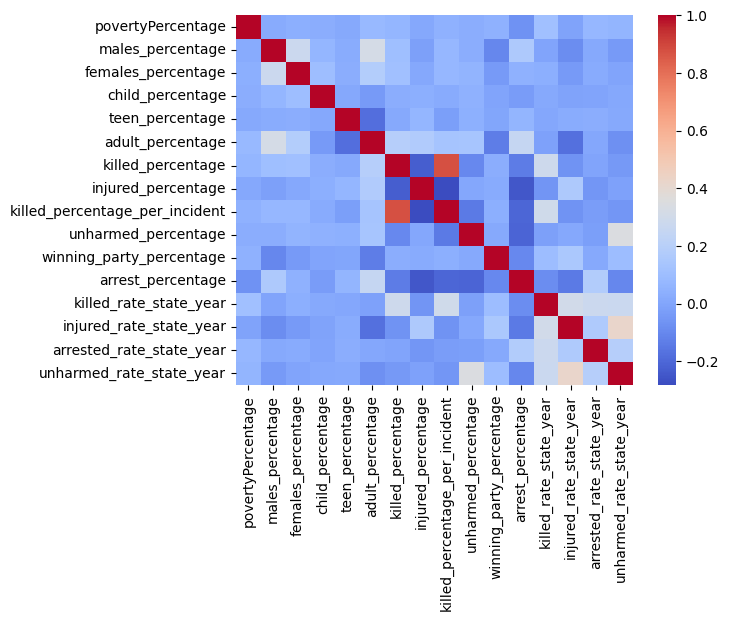

In [513]:
sns.heatmap(corr_matrix_ind, annot=False, cmap='coolwarm')

# Further Attributes dropped

As observed in the DU address will be dropped, moreover we will drop also year and notes because the former is a result of the data integration, useless because is redundant as we have the attribute date, the latter is useless because is only a string of text, used only in the data understanding

In [514]:
df.drop(columns=['notes', 'year', 'address'], inplace=True)

# Export the dataframe after the data preparation

In [515]:
df.to_csv('df_after_dp.csv', index=False)